In [ ]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt

# ---------- Parameters ----------
file_path = "16-07-2021_11-32-41.csv"
ecg_channel = "ECG_LL_RA"   # or "ECG_LA_RA", "ECG_Vx_RL", ...
rsp_channel = "ECG_RESP"
fs = 512                    # Hz

# ---------- Load and clean ----------
df = pd.read_csv(file_path)

# Drop the extra header row inside the data (where TIME == "TIME")
df = df[df["TIME"] != "TIME"].copy()

# Convert numeric columns
df["TIME"] = pd.to_numeric(df["TIME"], errors="coerce")
df[ecg_channel] = pd.to_numeric(df[ecg_channel], errors="coerce")
df[rsp_channel] = pd.to_numeric(df[rsp_channel], errors="coerce")

# Drop remaining NaNs
df = df.dropna(subset=["TIME", ecg_channel, rsp_channel]).reset_index(drop=True)

# Extract ECG signal and time
ecg = df[ecg_channel].values
rsp = df[rsp_channel].values
time = df["TIME"].values

# ---------- Detect R-peaks with NeuroKit2 ----------
ecg_signals, info = nk.ecg_process(ecg, sampling_rate=fs)
rsp_signals, rsp_info = nk.rsp_process(rsp, sampling_rate=fs)  # Process respiration if needed

# R-peak indices in samples
rpeaks_idx = info["ECG_R_Peaks"]

# Convert R-peaks to time
rpeaks_time = time[rpeaks_idx]

# ---------- Compute RR intervals ----------
rr_s = np.diff(rpeaks_time)          # in seconds
rr_ms = rr_s * 1000.0                # in ms

rr_df = pd.DataFrame({
    "R_index_prev": rpeaks_idx[:-1],
    "R_index_next": rpeaks_idx[1:],
    "R_time_prev_s": rpeaks_time[:-1],
    "R_time_next_s": rpeaks_time[1:],
    "RR_s": rr_s,
    "RR_ms": rr_ms
})

rr_df.to_csv("16-07-2021_11-32-41_RR_intervals.csv", index=False)
print(rr_df.head())

# ============================================================
#                       PLOTTING
# ============================================================

# ---------- 1) ECG segment with R-peaks ----------
# Choose a time window that you know has clean ECG
start_time = 30    # seconds
end_time   = 40    # seconds

segment_mask = (time >= start_time) & (time <= end_time)
time_seg = time[segment_mask]
ecg_seg = ecg[segment_mask]

# R-peaks within the same segment
rpeaks_seg_mask = (rpeaks_time >= start_time) & (rpeaks_time <= end_time)
rpeaks_time_seg = rpeaks_time[rpeaks_seg_mask]

# Get ECG amplitude at each R-peak (interpolate to be safe)
rpeaks_ecg_seg = np.interp(rpeaks_time_seg, time_seg, ecg_seg)

plt.figure(figsize=(10, 4))
plt.plot(time_seg, ecg_seg, label="ECG")
plt.plot(rpeaks_time_seg, rpeaks_ecg_seg, linestyle='None', marker='x', label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("ECG amplitude")
plt.title("ECG segment with detected R-peaks")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- 2) RR tachogram ----------
plt.figure(figsize=(8, 4))
plt.plot(rr_df["R_time_next_s"], rr_df["RR_ms"])
plt.xlabel("Time of beat (s)")
plt.ylabel("RR interval (ms)")
plt.title("RR tachogram")
plt.tight_layout()
plt.show()

# ---------- 3) RR histogram ----------
plt.figure(figsize=(6, 4))
plt.hist(rr_ms, bins=30)
plt.xlabel("RR interval (ms)")
plt.ylabel("Count")
plt.title("RR interval histogram")
plt.tight_layout()
plt.show()


C:\Users\liubo\AppData\Local\Temp\ipykernel_10392\2879611173.py:13: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


IndexError: index 0 is out of bounds for axis 0 with size 0

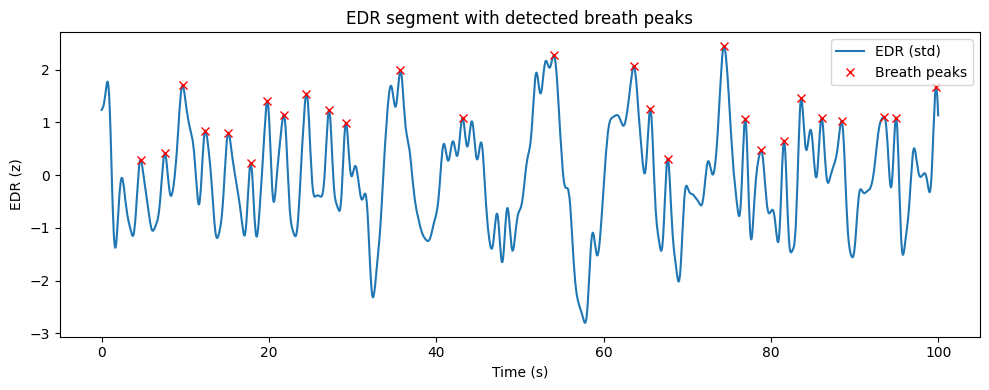

In [16]:
# ---------- ECG-derived respiration (EDR) ----------
# Heart-rate series from NeuroKit's ecg_process output
ecg_rate = signals["ECG_Rate"].values  # length matches ecg

# Convert heart rate to a respiratory proxy
edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")

# Optionally run standard RSP processing to get breath peaks & rate
rsp_signals, rsp_info = nk.rsp_process(edr, sampling_rate=fs)

# Peaks (breaths) from EDR-derived respiration
rsp_peaks_idx = rsp_info["RSP_Peaks"]
rsp_peaks_time = time[rsp_peaks_idx]  # same length as edr

# Plot a segment with peaks
edr_start, edr_end = 0, 100  # seconds
seg_mask = (time >= edr_start) & (time <= edr_end)
t_seg = time[seg_mask]
edr_seg = nk.standardize(edr[seg_mask])

peak_seg_mask = (rsp_peaks_time >= edr_start) & (rsp_peaks_time <= edr_end)
rsp_peaks_time_seg = rsp_peaks_time[peak_seg_mask]
rsp_peaks_amp_seg = np.interp(rsp_peaks_time_seg, t_seg, edr_seg)

plt.figure(figsize=(10, 4))
plt.plot(t_seg, edr_seg, label="EDR (std)")
plt.plot(rsp_peaks_time_seg, rsp_peaks_amp_seg, "rx", label="Breath peaks")
plt.xlabel("Time (s)")
plt.ylabel("EDR (z)")
plt.title("EDR segment with detected breath peaks")
plt.legend()
plt.tight_layout()
plt.show()



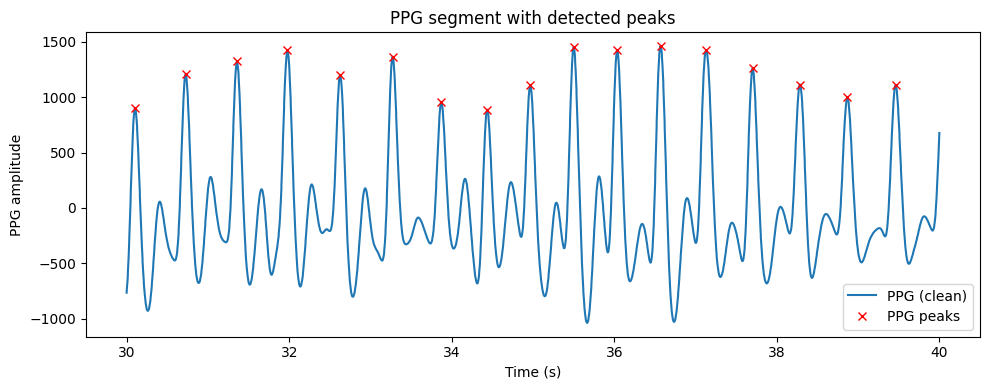

In [10]:
# ---------- PPG extraction & plotting ----------
ppg_raw = pd.to_numeric(df["GSR_PPG"], errors="coerce")
valid = ~ppg_raw.isna()
time_ppg = time[valid]
ppg = ppg_raw[valid].values

# Clean and get peaks
ppg_signals, ppg_info = nk.ppg_process(ppg, sampling_rate=fs)
ppg_clean = ppg_signals["PPG_Clean"]
ppg_peaks_idx = ppg_info["PPG_Peaks"]
ppg_peaks_time = time_ppg[ppg_peaks_idx]

# Plot a segment
ppg_start, ppg_end = 30, 40  # seconds
seg_mask = (time_ppg >= ppg_start) & (time_ppg <= ppg_end)
time_seg = time_ppg[seg_mask]
ppg_seg = ppg_clean[seg_mask]

peak_seg_mask = (ppg_peaks_time >= ppg_start) & (ppg_peaks_time <= ppg_end)
ppg_peaks_time_seg = ppg_peaks_time[peak_seg_mask]
ppg_peaks_amp_seg = np.interp(ppg_peaks_time_seg, time_seg, ppg_seg)

plt.figure(figsize=(10, 4))
plt.plot(time_seg, ppg_seg, label="PPG (clean)")
plt.plot(ppg_peaks_time_seg, ppg_peaks_amp_seg, "rx", label="PPG peaks")
plt.xlabel("Time (s)")
plt.ylabel("PPG amplitude")
plt.title("PPG segment with detected peaks")
plt.legend()
plt.tight_layout()
plt.show()


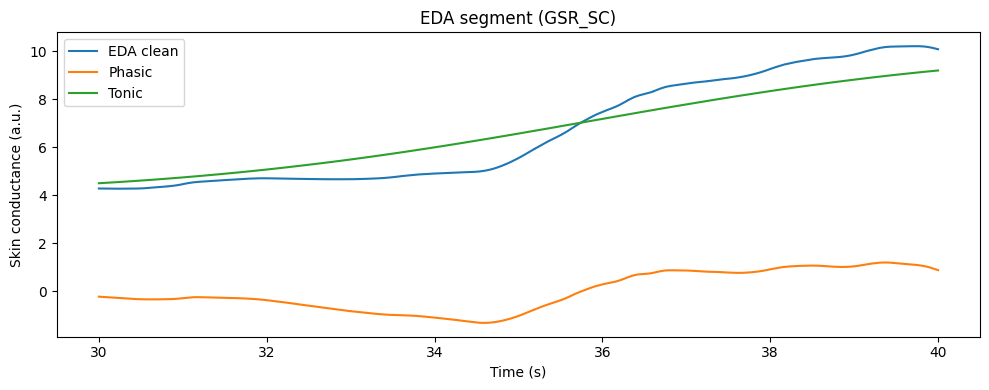

In [ ]:
# ---------- EDA processing & plotting ----------
eda_raw = pd.to_numeric(df["GSR_SC"], errors="coerce")
valid = ~eda_raw.isna()
time_eda = time[valid]
eda = eda_raw[valid].values

# Clean and decompose (phasic + tonic)
eda_signals, eda_info = nk.eda_process(eda, sampling_rate=fs)
eda_clean = eda_signals["EDA_Clean"]
eda_phasic = eda_signals["EDA_Phasic"]
eda_tonic = eda_signals["EDA_Tonic"]

# Plot a segment
eda_start, eda_end = 30, 40  # seconds
seg_mask = (time_eda >= eda_start) & (time_eda <= eda_end)
t_seg = time_eda[seg_mask]

plt.figure(figsize=(10, 4))
plt.plot(t_seg, eda_clean[seg_mask], label="EDA clean")
plt.plot(t_seg, eda_phasic[seg_mask], label="Phasic")
plt.plot(t_seg, eda_tonic[seg_mask], label="Tonic")
plt.xlabel("Time (s)")
plt.ylabel("Skin conductance (a.u.)")
plt.title("EDA segment (GSR_SC)")
plt.legend()
plt.tight_layout()
plt.show()

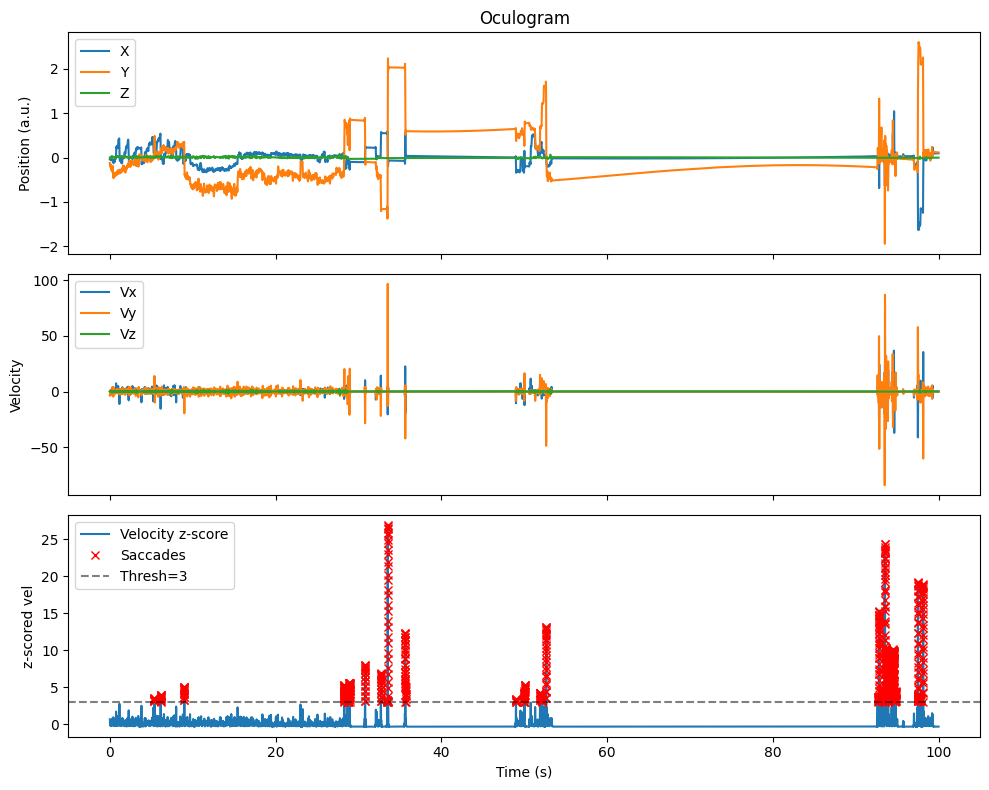

In [19]:
# ---------- Oculogram (X, Y, Z) ----------
# Load and clean
eog_x = pd.to_numeric(df["X"], errors="coerce")
eog_y = pd.to_numeric(df["Y"], errors="coerce")
eog_z = pd.to_numeric(df["Z"], errors="coerce")
valid = ~(eog_x.isna() | eog_y.isna() | eog_z.isna())

t_eog = time[valid]
x = eog_x[valid].values
y = eog_y[valid].values
z = eog_z[valid].values

# Detrend and bandpass to remove drift / high-frequency noise
x_f = nk.signal_filter(nk.signal_detrend(x), sampling_rate=fs, lowcut=0.01, highcut=15, order=4)
y_f = nk.signal_filter(nk.signal_detrend(y), sampling_rate=fs, lowcut=0.01, highcut=15, order=4)
z_f = nk.signal_filter(nk.signal_detrend(z), sampling_rate=fs, lowcut=0.01, highcut=15, order=4)

# Velocity (first derivative)
vx = np.gradient(x_f, 1 / fs)
vy = np.gradient(y_f, 1 / fs)
vz = np.gradient(z_f, 1 / fs)
v_mag = np.sqrt(vx**2 + vy**2 + vz**2)

# Simple saccade detection: z-score threshold on velocity magnitude
v_z = nk.standardize(v_mag)
saccade_idx = np.where(v_z > 3)[0]  # adjust threshold as needed
saccade_t = t_eog[saccade_idx]
saccade_amp = v_z[saccade_idx]

# Plot a segment
eog_start, eog_end = 0, 100
seg_mask = (t_eog >= eog_start) & (t_eog <= eog_end)

fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
axes[0].plot(t_eog[seg_mask], x_f[seg_mask], label="X")
axes[0].plot(t_eog[seg_mask], y_f[seg_mask], label="Y")
axes[0].plot(t_eog[seg_mask], z_f[seg_mask], label="Z")
axes[0].legend()
axes[0].set_ylabel("Position (a.u.)")
axes[0].set_title("Oculogram")

axes[1].plot(t_eog[seg_mask], vx[seg_mask], label="Vx")
axes[1].plot(t_eog[seg_mask], vy[seg_mask], label="Vy")
axes[1].plot(t_eog[seg_mask], vz[seg_mask], label="Vz")
axes[1].legend()
axes[1].set_ylabel("Velocity")

axes[2].plot(t_eog[seg_mask], v_z[seg_mask], label="Velocity z-score")
saccade_seg = (saccade_t >= eog_start) & (saccade_t <= eog_end)
axes[2].plot(saccade_t[saccade_seg], saccade_amp[saccade_seg], "rx", label="Saccades")
axes[2].axhline(3, color="k", linestyle="--", alpha=0.5, label="Thresh=3")
axes[2].legend()
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("z-scored vel")

plt.tight_layout()
plt.show()
